In [1]:
### MODEL TRAINING ###

In [12]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Load dataset
neither_vs_melkeratosis_features_targets = pd.read_csv('../neither_vs_melkeratosis_features_targets.csv')

In [3]:
neither_vs_melkeratosis_features_targets.head()

,image_id,red_median,red_iqr,green_iqr,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_InterquartileRange,original_firstorder_Range,original_glcm_Autocorrelation,original_gldm_LargeDependenceEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_ngtdm_Strength,mel_keratosis,neither
0,ISIC_0000000,94,67,65,169.60,182.00,6.00,46.00,7.10,5.23,3.00,0.60,2.63,0.05,0,1
1,ISIC_0000001,116,86,58,112.00,135.00,12.00,72.00,6.02,4.67,1.46,0.30,2.78,0.12,0,1
2,ISIC_0000002,161,26,52,157.00,169.00,6.00,38.00,3.99,5.05,1.50,0.38,1.93,0.94,1,0
3,ISIC_0000003,161,60,57,176.00,191.00,7.00,49.00,3.86,5.16,1.51,0.43,2.21,0.08,0,1
4,ISIC_0000004,192,36,44,26.00,205.00,159.00,210.00,31.01,4.67,1.55,0.27,4.28,2.21,1,0


In [4]:
# Train and test several models

# separate features and target
X = neither_vs_melkeratosis_features_targets.iloc[:,1:-2]
y = neither_vs_melkeratosis_features_targets[['mel_keratosis']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
# Preliminary model training and evaluation with LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.97it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.67               0.66     0.66      0.68   
PassiveAggressiveClassifier        0.65               0.65     0.65      0.67   
LGBMClassifier                     0.73               0.63     0.63      0.71   
BernoulliNB                        0.70               0.63     0.63      0.70   
BaggingClassifier                  0.74               0.62     0.62      0.72   
RandomForestClassifier             0.74               0.62     0.62      0.72   
GaussianNB                         0.70               0.62     0.62      0.70   
AdaBoostClassifier                 0.74               0.62     0.62      0.71   
XGBClassifier                      0.73               0.62     0.62      0.71   
LogisticRegression                 0.75               0.61     0.61      0.71   
NuSVC                       

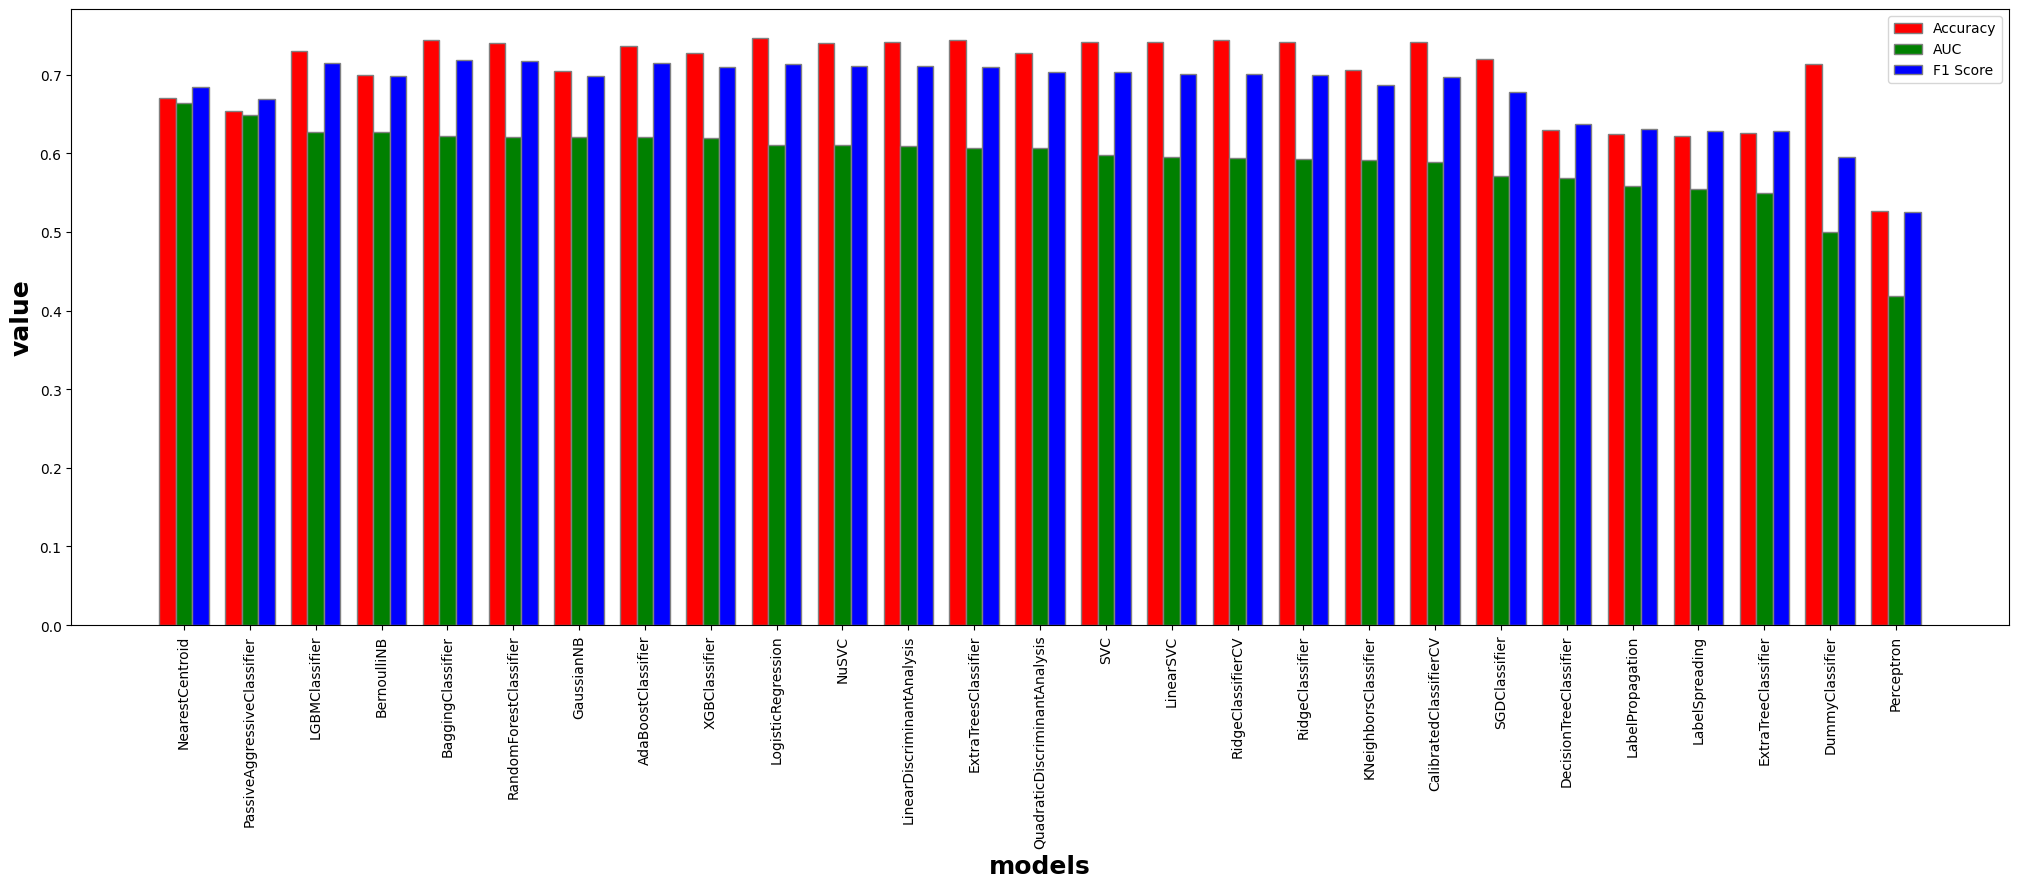

In [6]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(25, 8))

# set height of bar
acc = list(models['Accuracy'])
auc = list(models['ROC AUC'])
f1s = list(models['F1 Score'])

# Set position of bar on X axis
br1 = np.arange(len(acc))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, acc, color ='r', width = barWidth, edgecolor = 'grey', label ='Accuracy')
plt.bar(br2, auc, color ='g', width = barWidth, edgecolor = 'grey', label ='AUC')
plt.bar(br3, f1s, color ='b', width = barWidth, edgecolor = 'grey', label ='F1 Score')

# Adding Xticks
plt.xlabel('models', fontweight ='bold', fontsize = 18)
plt.ylabel('value', fontweight ='bold', fontsize = 18)
plt.xticks([r + barWidth for r in range(len(acc))], list(models.index))

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.legend()
plt.savefig('../plots/nm_model_acc_f1s.png', bbox_inches='tight')
plt.show()

In [7]:
# Optimizing Logistic Regression

In [8]:
log_clf = LogisticRegression(random_state=1)

In [13]:
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

In [14]:
print('Best score reached: {} with params: {} '.format(result.best_score_, result.best_params_))

Best score reached: 0.7175555555555555 with params: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'} 


In [15]:
y_predF = result.predict(X_test)

In [16]:
print('Model accuracy : {0:0.4f}'. format(accuracy_score(y_test, y_predF)))
print('Model recall : {0:0.4f}'. format(recall_score(y_test, y_predF, average='weighted') ))
print('Model roc/auc : {0:0.4f}'. format(roc_auc_score(y_test, y_predF), 
                                                       average="macro"))

Model accuracy : 0.7460
Model recall : 0.7460
Model roc/auc : 0.6125


In [1]:
# SVM (SVC)

In [17]:
svc=SVC(C=100.0)

In [18]:
# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.7420


In [19]:
print('Model accuracy : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Model recall : {0:0.4f}'. format(recall_score(y_test, y_pred, average='weighted') ))
print('Model roc/auc : {0:0.4f}'. format(roc_auc_score(y_test, y_pred), 
                                                       average="macro"))

Model accuracy : 0.7420
Model recall : 0.7420
Model roc/auc : 0.5909
